# Bayesian Linear Regression

When we perform linear regression using maximum likelihood estimation, we obtain a point estimate of the parameters $\mathbf{w}$ of the linear model. The Bayesian approach to this problem is to treat the parameters of the model as random variables for which we have a prior belief on their uncertainty, corresponding to the distribution $p(\mathbf{w}\mid \alpha)$. If we get observations $\mathcal{D}$ of the phenomenon that we are trying to model, we can calculate the likelihood $p(\mathcal{D}\mid \mathbf{w})$ and then update our beliefs on the parameters of the model by calculating the posterior distribution $p(\mathbf{w}\mid \mathcal{D}, \alpha)$, which from Bayes' theorem is

$$p(\mathbf{w}\mid \mathcal{D}, \alpha) = \frac{p(\mathbf{w}\mid \alpha)p(\mathbf{w}\mid \alpha)}{p(\mathcal{D})}$$

For some distributions, we can derive an update rule that can be used for learning from data. We will apply this Bayesian learning to a simple linear model that can be easily visualized. 

## Likelihood function
Suppose we are taking measurements of a variable $t$ that depends on a variable $x$ and contains some normal noise $\epsilon$ with inverse variance $\beta^{-1}$. We can thus model $t$ as being a parametric function of $x$ with parameters $\mathbf{w}$, which we will denote as $y(x,\mathbf{w})$, plus normally distributed noise with zero mean and known variance, therefore

$$p(t\mid x,\mathbf{w},\beta^{-1}) = \mathcal{N}(t\mid y(x,\mathbf{w}),\beta^{-1})$$

If we observe a value $t$ for a given $x$, then this is a function of the parameters $\mathbf{w}$.

For a simple example, let $x\in\mathbb{R}$, $t\in\mathbb{R}$ and let our parametric function be a linear function of $x$ so that

$$y(x,\mathbf{w}) = w_0 + w_1 x$$

Furthermore, we will assume a known precision $\beta$ of 25 which corresponds to a standard deviation of 0.2. We can then visualize the likelihood function for different values of $\mathbf{w} = (w_0, w_1)^T$  given that we observe a data point with $x=1.5$ and $t=1$. Note how in the code $x$ is a vector whose first element is always one, which account for the bias term that is then multiplied by $w_0$.

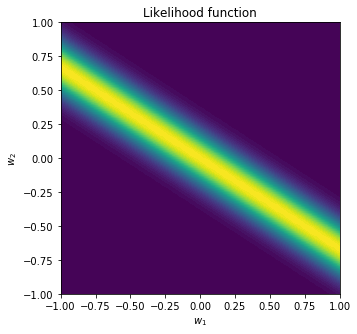

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
np.random.seed(42)

beta = 25
def likelihood(x, t, w):
    likelihood_vals = stats.norm(W @ x, 1/np.sqrt(beta)).pdf(t)
    return np.squeeze(likelihood_vals)

# We will evaluate the likelihood function for different values of w
N = 50
w = np.linspace(-1, 1, N)
W = np.dstack(np.meshgrid(w, w))
# Observation
x = np.array([[1, 1.5]]).T
t = 1

# Plot likelihood function
plt.figure(figsize=(5,5))
plt.contourf(w, w, likelihood(x, 0, W), N)
plt.title('Likelihood function')
plt.xlabel('$w_1$')
plt.ylabel('$w_2$');

We can see that given an observed data point and under the linear model we selected, some values of $\mathbf{w}$ are more likely than others.

## Prior distribution

Our prior beliefs on the distribution of the parameters can be conveniently expressed using a Gaussian conjugate prior with zero mean and isotropic covariance:
$$p(\mathbf{w},\alpha)=\mathcal{N}(\mathbf{w}\mid \mathbf{m}_0, \mathbf{S}_0)=\mathcal{N}(\mathbf{w}\mid 0, \alpha^{-1}\mathbf{I})$$

The reason it's called conjugate is because when calculating the posterior, we again obtain a Gaussian distribution (which is what makes it convenient). We can also plot this distribution in the parameter space, choosing $\alpha=2$.

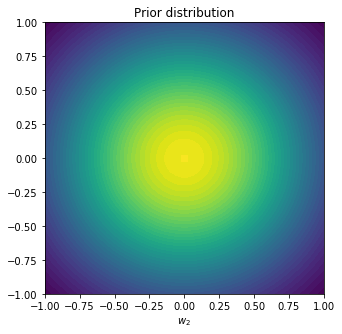

In [2]:
alpha = 2
def prior(w, mean=None, cov=None):
    if mean is None and cov is None:
        mean = np.array([[0, 0]]).T
        cov = 1/alpha * np.identity(2)
    prior_vals = stats.multivariate_normal(mean.flatten(), cov).pdf(w)
    return prior_vals

plt.figure(figsize=(5,5))
plt.contourf(w, w, prior(W), N);
plt.title('Prior distribution')
plt.xlabel('$w_1$')
plt.xlabel('$w_2$');

# Posterior distribution

Now we can finally start learning from data. Given new observations, we can update our prior distribution using Bayes' theorem to obtain a posterior distribution (see [1] for derivations). Since we chose a conjugate prior, the posterior turns out to be Gaussian too. Given a single observed data point consisting of an input $x$ and an output $y$, let's define $\mathbf{x}=(1, x)^T$. The posterior is then
$$p(\mathbf{w}\mid t) = \mathcal{N}(\mathbf{w}\mid \mathbf{m}_1,\mathbf{S}_1)$$
with
$$\mathbf{m}_1 = \mathbf{S}_1 (\mathbf{S}_0^{-1} \mathbf{m}_0 + \beta t \mathbf{x})$$
$$\mathbf{S}_1 = \left(\mathbf{S}_0^{-1} + \beta\mathbf{x}\mathbf{x}^T\right)^{-1}$$
This forms a sequential update rule for the posterior distribution: each time we observe a new data point, the posterior covariance $\mathbf{S}_1$ is calculated from the prior covariance $\mathbf{S}_0$, and then the posterior mean is updated using $\mathbf{S}_1$.
In addition to this, we can also calculate the predictive distribution for any value of $t$ given $\mathbf{x}$, by computing the joint distribution of $t$ and $\mathbf{w}$ and marginalizing out the parameters $\mathbf{w}$. This results in a normal distribution, for any $t$, with mean $\mathbf{m}_1^T \mathbf{x}$ and variance
$$\frac{1}{\beta} + \mathbf{x}^T\mathbf{S}_1\mathbf{x}$$

To illustrate this sequential learning process, we will define our true data generating process. We will then draw one point at a time at random from it and use it to update the posterior distribution of the parameters as we just described. We will observe how the posterior changes as well as the predictive distribution as we obtain more observations.

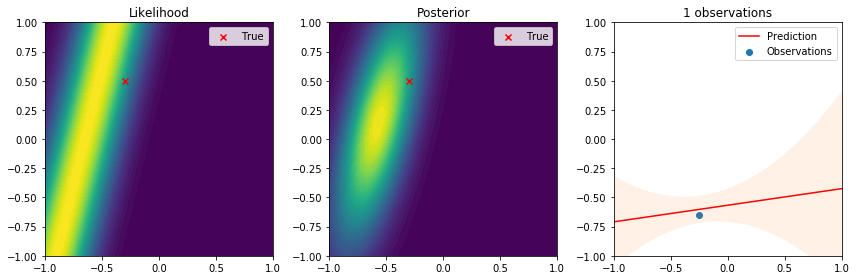

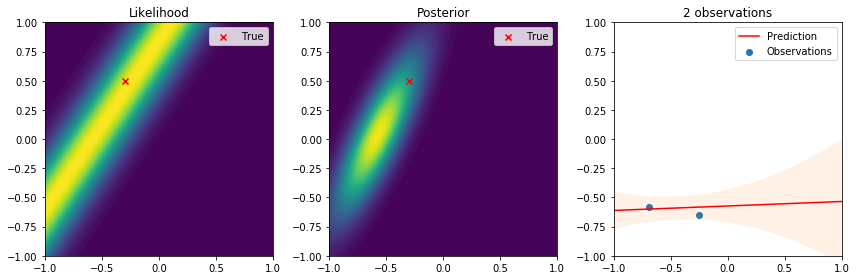

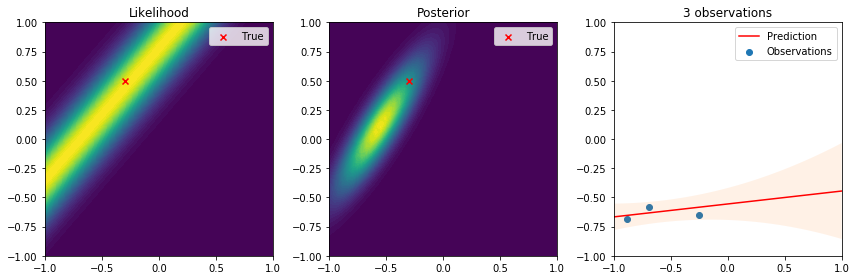

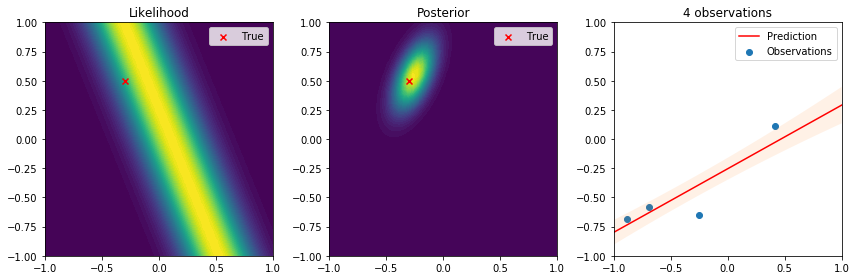

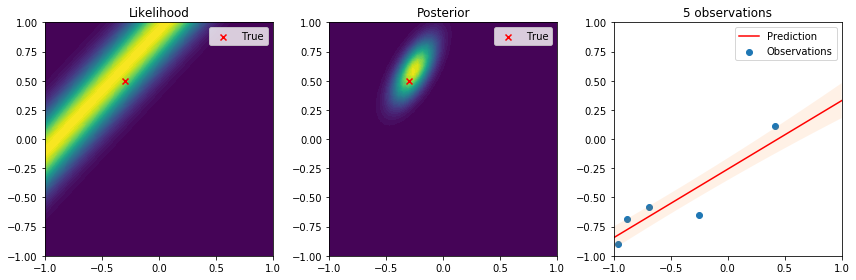

In [3]:
def sample_true_model():
    # True parameters
    a = np.array([-0.3, 0.5]).T
    x = np.array([[1, 2*np.random.random() - 1]]).T
    t = a.T @ x + np.random.normal(0, 0.2)
    return x, t

# Prior distribution parameters
m_0 = np.array([[0, 0]]).T
S_0 = 1/alpha * np.identity(2)

n_points = 5
obs_x = []
obs_t = []
for n in range(n_points):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    
    # Get new data point
    x, t = sample_true_model()
    
    # Plot likelihood
    plt.contourf(w, w, likelihood(x, t, W), N)
    plt.scatter(-0.3, 0.5, c='r', marker='x', label='True')
    plt.title('Likelihood')
    plt.legend()
    
    # Calculate posterior covariance and mean
    S_0_inv = np.linalg.inv(S_0)
    S_1 = np.linalg.inv(S_0_inv + beta * x @ x.T)    
    m_1 = S_1 @ (S_0_inv @ m_0 + beta * t * x)
    
    # Plot posterior
    plt.subplot(1, 3, 2)
    plt.contourf(w, w, prior(W, mean=m_1, cov=S_1), N)
    plt.scatter(-0.3, 0.5, c='r', marker='x', label='True')
    plt.title('Posterior')
    plt.legend()
    
    # Plot observations
    obs_x.append(x[1])
    obs_t.append(t)
    plt.subplot(1, 3, 3)    
    plt.scatter(obs_x, obs_t, label='Observations')
    # Add predictive mean
    n_pred = 100
    x_pred = np.vstack((np.ones(n_pred), np.linspace(-1, 1, n_pred)))
    pred_mean = m_1.T @ x_pred
    pred_var = np.sum(1/beta + x_pred.T @ S_1 * x_pred.T, axis=1)
    plt.plot(x_pred[1,:], pred_mean.T, 'r', label='Prediction')
    # Add predictive variance
    minus_var = pred_mean.flatten() - pred_var
    plus_var = pred_mean.flatten() + pred_var
    plt.fill_between(x_pred[1,:], minus_var, plus_var, alpha=0.1);
    plt.title('{:d} observations'.format(n + 1))
    plt.xlim((-1,1))
    plt.ylim((-1,1))
    plt.legend()
    
    plt.tight_layout()
    
    # For the next data point, the posterior will be a prior
    S_0 = S_1.copy()
    m_0 = m_1.copy()    

There are many interesting things to highlight from these results. First, we see that the true parameter always lies in regions of high likelihood, which follows the definition of the likelihood function. From the posterior distribution we can see that as the number of data points increases, the uncertainty in the parameters is reduced and converges to the true parameter. Lastly, on the right the observations give us an idea of the variance introduced by the noise. The resulting predictive distribution is a very useful model because instead of just giving point estimates (as those obtained by maximum likelihood estimation), we obtain a fully probabilistic prediction that accounts for the uncertainty in the parameters in relation to the samples used to update the model. Therefore, the variance in the prediction is high in regions where samples have not been observed, and reduced in regions where samples have been observed. This is one of the reasons why Bayesian learning is a powerful tool to make decisions backed by credible intervals.

### References
[1] Christopher, M. B. (2016). Pattern Recognition and Machine Learning. Springer-Verlag New York.